### features:
* selected spectogram coef
* zero crossing rate
* selected chromogram values
* selected tempogram values
* wavelet of level 0

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
import itertools

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
csv_path = "/Users/ecem/Desktop/csv of scgs"
wavelet_csv = "/Users/ecem/Desktop/wavelet-csv"

## Load data

Here, our target is to predict disease correctly. So; our y will be disease column of  dataset

## Training data

In [3]:
spec_t = pd.read_csv(csv_path + '/p-value-selected-intersection-spec.csv', index_col = 0)
#spec  #uncomment to see dataframe

signal_proc_t = pd.read_csv(csv_path + '/signal_processing.csv', index_col = 0)
labels= signal_proc_t.disease

zero_crossing_t = signal_proc_t.iloc[:,:21]
#zero_crossing #uncomment to see dataframe

tempogram_t = pd.read_csv(csv_path + '/p-value-selected-tempogram.csv', index_col = 0)
#tempogram #uncomment to see dataframe

chromogram_t = pd.read_csv(csv_path + '/p-value-selected-chromogram.csv', index_col = 0)
#chromogram #uncomment to see dataframe

w_lvl0_t = pd.read_csv(wavelet_csv + '/wavelet_lvl0.csv', index_col = 0).drop(['disease'], axis =1)

In [4]:
features_t = pd.concat([spec_t, w_lvl0_t], axis = 1)
features_t = pd.concat([features_t, zero_crossing_t], axis = 1)
features_t = pd.concat([features_t, chromogram_t], axis = 1)
features_t = pd.concat([features_t, tempogram_t], axis = 1)

features_t

,freq_y1772,freq_z1773,freq_z1774,freq_x555,freq_y555,freq_z555,freq_x556,freq_y556,freq_z556,freq_x557,...,tempogram_y256,tempogram_z320,tempogram_y320,tempogram_x320,tempogram_z319,tempogram_y318,tempogram_z318,tempogram_x319,tempogram_y319,tempogram_z255
0,0.001532,0.001640,0.001674,0.001893,0.001943,0.002011,0.002095,0.002203,0.002324,0.002456,...,0.530600,1.995912e-09,2.077070e-08,9.243277e-08,2.790526e-07,0.000005,0.000003,1.396714e-06,6.724008e-07,0.655776
1,0.001081,0.001133,0.001150,0.001956,0.001950,0.001976,0.002043,0.002175,0.002353,0.002550,...,0.500824,2.028191e-09,2.127964e-08,9.563631e-08,2.903866e-07,0.000005,0.000003,1.453675e-06,7.007032e-07,0.698621
2,0.000998,0.001007,0.001074,0.001647,0.001771,0.001908,0.002053,0.002199,0.002334,0.002454,...,0.625713,2.126909e-09,2.210467e-08,9.798902e-08,2.938337e-07,0.000005,0.000003,1.448168e-06,7.024096e-07,0.723520
3,0.001562,0.001501,0.001514,0.001808,0.001872,0.001936,0.002013,0.002083,0.002142,0.002194,...,0.529697,2.047285e-09,2.139673e-08,9.564295e-08,2.891187e-07,0.000005,0.000003,1.442187e-06,6.958695e-07,0.683446
4,0.001472,0.001202,0.001115,0.002248,0.002256,0.002248,0.002224,0.002187,0.002146,0.002128,...,0.598515,2.072857e-09,2.163759e-08,9.658166e-08,2.917338e-07,0.000005,0.000003,1.455662e-06,7.020410e-07,0.721680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,0.001216,0.001121,0.001128,0.002108,0.002052,0.002002,0.001956,0.001907,0.001861,0.001818,...,0.641036,2.088920e-09,2.177164e-08,9.693865e-08,2.919924e-07,0.000005,0.000003,1.448547e-06,7.006018e-07,0.750267
1458,0.001336,0.001130,0.001091,0.002863,0.002948,0.003014,0.003061,0.003078,0.003063,0.003022,...,0.787490,1.887310e-09,1.959960e-08,8.681271e-08,2.604164e-07,0.000004,0.000002,1.292420e-06,6.240085e-07,0.826712
1459,0.000972,0.001104,0.001221,0.002500,0.002394,0.002317,0.002291,0.002291,0.002301,0.002303,...,0.932019,1.179492e-09,1.237183e-08,5.552285e-08,1.685724e-07,0.000003,0.000002,8.614300e-07,4.093625e-07,0.942913
1460,0.001339,0.001275,0.001377,0.002584,0.002671,0.002758,0.002842,0.002910,0.002953,0.002970,...,0.863513,1.440790e-09,1.494368e-08,6.590384e-08,1.959676e-07,0.000003,0.000002,9.476128e-07,4.638441e-07,0.910716


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(labels)
label

array([2, 2, 2, ..., 1, 1, 1])

In [6]:
le.classes_

array(['AR', 'AS', 'MR', 'MS'], dtype=object)

## Test data

In [7]:
spec = pd.read_csv(csv_path + '/p-value-selected-intersection-multiple-dis-spec.csv', index_col = 0)
#spec  #uncomment to see dataframe

signal_proc = pd.read_csv(csv_path + '/multiple-disease-final-signal_processing.csv', index_col = 0)
y1 = signal_proc.disease1
y2 = signal_proc.disease2

zero_crossing = signal_proc.iloc[:,:21]
#zero_crossing #uncomment to see dataframe

tempogram = pd.read_csv(csv_path + '/p-value-selected-multiple-dis-temp.csv', index_col = 0)
#tempogram #uncomment to see dataframe

chromogram = pd.read_csv(csv_path + '/p-value-selected-multiple-dis-chromogram.csv', index_col = 0)
#chromogram #uncomment to see dataframe

w_lvl0 = pd.read_csv(csv_path + '/multiple-disease-wavelet-lvl0-coef.csv', index_col = 0).drop(['disease1', 'disease2'], axis =1)
w_lvl0 = w_lvl0.reset_index(drop=True)
#w_lvl0  #uncomment to see dataframe

In [8]:
#spec

In [9]:
#signal_proc

In [10]:
#zero_crossing

In [11]:
#tempogram

In [12]:
#chromogram

In [13]:
#w_lvl0

In [14]:
features = pd.concat([spec, w_lvl0], axis = 1)
features = pd.concat([features, zero_crossing], axis = 1)
features = pd.concat([features, chromogram], axis = 1)
features = pd.concat([features, tempogram], axis = 1)

features

,freq_y1772,freq_z1773,freq_z1774,freq_x555,freq_y555,freq_z555,freq_x556,freq_y556,freq_z556,freq_x557,...,tempogram_y256,tempogram_z320,tempogram_y320,tempogram_x320,tempogram_z319,tempogram_y318,tempogram_z318,tempogram_x319,tempogram_y319,tempogram_z255
0,0.003383,0.002980,0.002855,0.002161,0.002094,0.002025,0.001971,0.001921,0.001869,0.001812,...,0.445113,1.978267e-09,2.062070e-08,9.183201e-08,2.766100e-07,0.000004,2.549855e-06,1.371246e-06,6.635903e-07,0.618049
1,0.004910,0.004310,0.004276,0.001875,0.002008,0.002132,0.002238,0.002317,0.002364,0.002378,...,0.538619,2.086170e-09,2.166218e-08,9.600761e-08,2.882793e-07,0.000005,2.655965e-06,1.426979e-06,6.905931e-07,0.654835
2,0.004735,0.004130,0.003788,0.002241,0.002232,0.002200,0.002142,0.002063,0.001966,0.001855,...,0.608095,2.098638e-09,2.191610e-08,9.778785e-08,2.947368e-07,0.000005,2.711798e-06,1.459085e-06,7.067081e-07,0.741303
3,0.004367,0.004345,0.004337,0.002082,0.002036,0.001993,0.001960,0.001941,0.001943,0.001987,...,0.715791,2.025586e-09,2.105369e-08,9.338860e-08,2.804590e-07,0.000004,2.585357e-06,1.388093e-06,6.717521e-07,0.788690
4,0.004148,0.003581,0.003203,0.001680,0.001666,0.001645,0.001618,0.001595,0.001595,0.001607,...,0.767121,1.932686e-09,2.006646e-08,8.889795e-08,2.668415e-07,0.000004,2.468796e-06,1.322954e-06,6.394051e-07,0.819613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.001908,0.002203,0.002238,0.002802,0.002739,0.002655,0.002559,0.002466,0.002393,0.002345,...,0.364195,2.059336e-09,2.124141e-08,9.317839e-08,2.766343e-07,0.000004,2.460065e-06,1.337205e-06,6.549272e-07,0.521096
323,0.001781,0.002088,0.002148,0.004011,0.003909,0.003803,0.003701,0.003584,0.003453,0.003323,...,0.277581,1.249031e-09,1.333401e-08,6.137947e-08,1.903869e-07,0.000003,1.851025e-06,9.828763e-07,4.674462e-07,0.671185
324,0.001544,0.001566,0.001578,0.002893,0.002796,0.002694,0.002628,0.002590,0.002553,0.002508,...,0.407483,1.720723e-09,1.811135e-08,8.183620e-08,2.500919e-07,0.000004,2.378340e-06,1.268592e-06,6.076013e-07,0.655393
325,0.000873,0.001025,0.001021,0.002950,0.002898,0.002809,0.002688,0.002544,0.002399,0.002275,...,0.270778,1.720426e-09,1.781081e-08,7.853572e-08,2.342196e-07,0.000004,2.101861e-06,1.139776e-06,5.565471e-07,0.476264


In [15]:
y1 = le.transform(y1)
y1

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [16]:
y2 = le.transform(y2)
y2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [17]:
stack = np.stack((y1,y2), axis = 1)
y = pd.DataFrame(stack, columns =['disease1', 'disease2'])
y

,disease1,disease2
0,2,1
1,2,1
2,2,1
3,2,1
4,2,1
...,...,...
322,3,2
323,3,2
324,3,2
325,3,2


In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(features_t, label, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [19]:
import xgboost as xgb
model  = xgb.XGBClassifier(random_state = 42, objective='multi:softprob', eval_metric = 'merror') 

# Fit the model
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [20]:
predictions = model.predict(X_valid)

In [21]:
predictions.shape

(293,)

In [22]:
prob = model.predict_proba(X_valid)
prob = np.moveaxis(prob, -1, 0)

In [23]:
prob.shape

(4, 293)

In [24]:
y['disease1']

0      2
1      2
2      2
3      2
4      2
      ..
322    3
323    3
324    3
325    3
326    3
Name: disease1, Length: 327, dtype: int64

In [25]:
df_results = pd.DataFrame({'actual':y_valid,
                           'prediction':predictions, 'probability of 0': prob[0],
                          'probability of 1': prob[1],
                          'probability of 2': prob[2], 
                          'probability of 3': prob[3],  })
df_results

,actual,prediction,probability of 0,probability of 1,probability of 2,probability of 3
0,3,3,0.001482,0.015378,0.001829,0.981311
1,1,1,0.000969,0.623919,0.369047,0.006064
2,2,2,0.000762,0.105099,0.893065,0.001074
3,2,2,0.001479,0.005452,0.992835,0.000234
4,1,1,0.003631,0.775374,0.203027,0.017967
...,...,...,...,...,...,...
288,1,1,0.004684,0.950075,0.043833,0.001408
289,0,0,0.985678,0.002927,0.007149,0.004246
290,0,0,0.910399,0.010160,0.071772,0.007670
291,0,0,0.998826,0.000071,0.001060,0.000044


In [26]:
AR_df  = df_results.loc[df_results['actual']== 0]
AR_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,50.000000,50.000000,50.000000,50.000000
mean,0.883259,0.030319,0.083610,0.002811
std,0.246058,0.080555,0.193245,0.005478
min,0.000570,0.000040,0.000244,0.000018
25%,0.912596,0.000429,0.002000,0.000088
50%,0.985573,0.003268,0.008230,0.000455
75%,0.997581,0.009774,0.068835,0.003293
max,0.999631,0.401665,0.988963,0.026137


In [27]:
AS_df  = df_results.loc[df_results['actual']== 1]
AS_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,97.000000,97.000000,97.000000,97.000000
mean,0.004850,0.822344,0.167061,0.005745
std,0.013927,0.245045,0.239571,0.022622
min,0.000030,0.028272,0.000054,0.000006
25%,0.000358,0.749874,0.006962,0.000378
50%,0.000933,0.941293,0.044540,0.000940
75%,0.003510,0.991933,0.231548,0.002807
max,0.116428,0.999892,0.970788,0.208190


In [28]:
MR_df  = df_results.loc[df_results['actual']== 2]
MR_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,118.000000,118.000000,118.000000,118.000000
mean,0.051223,0.090870,0.853362,0.004546
std,0.182589,0.170327,0.244973,0.012861
min,0.000034,0.000290,0.032311,0.000030
25%,0.000253,0.003703,0.832599,0.000233
50%,0.000803,0.020035,0.967057,0.000499
75%,0.004528,0.072862,0.991666,0.001899
max,0.965437,0.848493,0.999320,0.087351


In [29]:
MS_df  = df_results.loc[df_results['actual']== 3]
MS_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,28.000000,28.000000,28.000000,28.000000
mean,0.065794,0.020695,0.100275,0.813237
std,0.162514,0.031693,0.250593,0.319306
min,0.000032,0.000081,0.000050,0.001867
25%,0.000084,0.002598,0.000987,0.810881
50%,0.000398,0.007184,0.003196,0.985163
75%,0.002752,0.020025,0.041414,0.997057
max,0.595792,0.117038,0.976693,0.999541


In [30]:
predictions_test = model.predict(features)

In [31]:
predictions_test.shape

(327,)

In [32]:
prob_test = model.predict_proba(features)
prob_test = np.moveaxis(prob_test, -1, 0)

In [33]:
prob_test.shape

(4, 327)

In [34]:
df_results_test = pd.DataFrame({'actual disease1': y['disease1'], 'actual disease2': y['disease2'],
                                'prediction':predictions_test, 'probability of 0': prob_test[0],
                          'probability of 1': prob_test[1],
                          'probability of 2': prob_test[2], 
                          'probability of 3': prob_test[3]  })
df_results_test

,actual disease1,actual disease2,prediction,probability of 0,probability of 1,probability of 2,probability of 3
0,2,1,2,0.029394,0.127270,0.817945,0.025392
1,2,1,3,0.004678,0.020770,0.476382,0.498169
2,2,1,2,0.005238,0.163244,0.791982,0.039535
3,2,1,2,0.001939,0.274575,0.549704,0.173781
4,2,1,2,0.002210,0.209699,0.757869,0.030222
...,...,...,...,...,...,...,...
322,3,2,3,0.345465,0.058446,0.179026,0.417063
323,3,2,3,0.011268,0.040976,0.110018,0.837738
324,3,2,3,0.335547,0.066632,0.188880,0.408942
325,3,2,0,0.633702,0.078915,0.274771,0.012612


In [35]:
y 
#mr as  #2 1
#mr ar  #2 0
#ar as  #0 1
#ms as  #3 1
#ms mr  #3 2


,disease1,disease2
0,2,1
1,2,1
2,2,1
3,2,1
4,2,1
...,...,...
322,3,2
323,3,2
324,3,2
325,3,2


In [36]:
MR_AS_df  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 2) &
                                 (df_results_test['actual disease2']== 1))]
#MR_AS_df
MR_AS_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,82.000000,82.000000,82.000000,82.000000
mean,0.110012,0.247149,0.570817,0.072023
std,0.226414,0.264530,0.381543,0.136341
min,0.000106,0.002258,0.002739,0.000095
25%,0.002256,0.034454,0.111732,0.001333
50%,0.008639,0.136206,0.742705,0.005795
75%,0.052474,0.394246,0.936153,0.109546
max,0.978036,0.930744,0.993544,0.876279


In [37]:
MR_AR_df  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 2) &
                                 (df_results_test['actual disease2']== 0))]
#MR_AR_df
MR_AR_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,82.000000,82.000000,82.000000,82.000000
mean,0.110012,0.247149,0.570817,0.072023
std,0.226414,0.264530,0.381543,0.136341
min,0.000106,0.002258,0.002739,0.000095
25%,0.002256,0.034454,0.111732,0.001333
50%,0.008639,0.136206,0.742705,0.005795
75%,0.052474,0.394246,0.936153,0.109546
max,0.978036,0.930744,0.993544,0.876279


In [38]:
MR_test_df1  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 2))]
#MR_test_df1
MR_test_df1[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,164.000000,164.000000,164.000000,164.000000
mean,0.110012,0.247149,0.570817,0.072023
std,0.225718,0.263717,0.380370,0.135922
min,0.000106,0.002258,0.002739,0.000095
25%,0.002210,0.033537,0.111396,0.001326
50%,0.008639,0.136206,0.742705,0.005795
75%,0.053960,0.399919,0.938119,0.112397
max,0.978036,0.930744,0.993544,0.876279


In [39]:
MR_test_df2  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease2']== 2))]
#MR_test_df2
MR_test_df2[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,38.000000,38.000000,38.000000,38.000000
mean,0.052919,0.214500,0.504977,0.227604
std,0.144275,0.218199,0.330577,0.238244
min,0.000196,0.009945,0.008722,0.000844
25%,0.000535,0.041123,0.205195,0.032351
50%,0.001156,0.102483,0.455346,0.151350
75%,0.007267,0.392076,0.844946,0.352438
max,0.633702,0.755220,0.970408,0.939075


In [40]:
AR_AS_df  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 0) &
                                 (df_results_test['actual disease2']== 1))]
#AR_AS_df
AR_AS_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,43.000000,43.000000,43.000000,43.000000
mean,0.001225,0.051985,0.896076,0.050714
std,0.004813,0.089275,0.192586,0.134087
min,0.000074,0.000959,0.073360,0.000113
25%,0.000132,0.004220,0.894892,0.000379
50%,0.000233,0.012005,0.976621,0.001388
75%,0.000499,0.046695,0.994763,0.015253
max,0.031722,0.341162,0.998531,0.553756


In [41]:
AR_test_df1  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 0))]
#AR_test_df1
AR_test_df1[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,43.000000,43.000000,43.000000,43.000000
mean,0.001225,0.051985,0.896076,0.050714
std,0.004813,0.089275,0.192586,0.134087
min,0.000074,0.000959,0.073360,0.000113
25%,0.000132,0.004220,0.894892,0.000379
50%,0.000233,0.012005,0.976621,0.001388
75%,0.000499,0.046695,0.994763,0.015253
max,0.031722,0.341162,0.998531,0.553756


In [43]:
AR_test_df2  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease2']== 0))]
#AR_test_df2
AR_test_df2[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,82.000000,82.000000,82.000000,82.000000
mean,0.110012,0.247149,0.570817,0.072023
std,0.226414,0.264530,0.381543,0.136341
min,0.000106,0.002258,0.002739,0.000095
25%,0.002256,0.034454,0.111732,0.001333
50%,0.008639,0.136206,0.742705,0.005795
75%,0.052474,0.394246,0.936153,0.109546
max,0.978036,0.930744,0.993544,0.876279


In [44]:
MS_AS_df  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 3) &
                                 (df_results_test['actual disease2']== 1))]
#MS_AS_df
MS_AS_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,82.000000,82.000000,82.000000,82.000000
mean,0.002458,0.427303,0.565004,0.005235
std,0.003985,0.356188,0.357815,0.005886
min,0.000100,0.002270,0.015346,0.000464
25%,0.000471,0.026320,0.210880,0.001679
50%,0.001221,0.415583,0.561619,0.003217
75%,0.002527,0.776531,0.970869,0.007130
max,0.028033,0.983187,0.995849,0.032992


In [45]:
MS_MR_df  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 3) &
                                 (df_results_test['actual disease2']== 2))]
#MS_MR_df
MS_MR_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,38.000000,38.000000,38.000000,38.000000
mean,0.052919,0.214500,0.504977,0.227604
std,0.144275,0.218199,0.330577,0.238244
min,0.000196,0.009945,0.008722,0.000844
25%,0.000535,0.041123,0.205195,0.032351
50%,0.001156,0.102483,0.455346,0.151350
75%,0.007267,0.392076,0.844946,0.352438
max,0.633702,0.755220,0.970408,0.939075


In [46]:
MS_test_df1  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 3))]
#MS_test_df1
MS_test_df1[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,120.000000,120.000000,120.000000,120.000000
mean,0.018438,0.359915,0.545996,0.075652
std,0.083895,0.333229,0.349159,0.168706
min,0.000100,0.002270,0.008722,0.000464
25%,0.000489,0.038765,0.205807,0.002292
50%,0.001221,0.261529,0.521713,0.005764
75%,0.002791,0.643598,0.921797,0.030647
max,0.633702,0.983187,0.995849,0.939075


In [47]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y.disease1, predictions_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

recall = recall_score(y.disease1, predictions_test, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))

from sklearn.metrics import precision_score
precision = precision_score(y.disease1, predictions_test, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

Accuracy: 35.17%
recall: 35.17%
precision: 47.09%


/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
accuracy = accuracy_score(y.disease2, predictions_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

recall = recall_score(y.disease2, predictions_test, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))

from sklearn.metrics import precision_score
precision = precision_score(y.disease2, predictions_test, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

Accuracy: 25.69%
recall: 25.69%
precision: 55.90%


/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
classes = ['AR', 'AS', 'MR', 'MS']

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


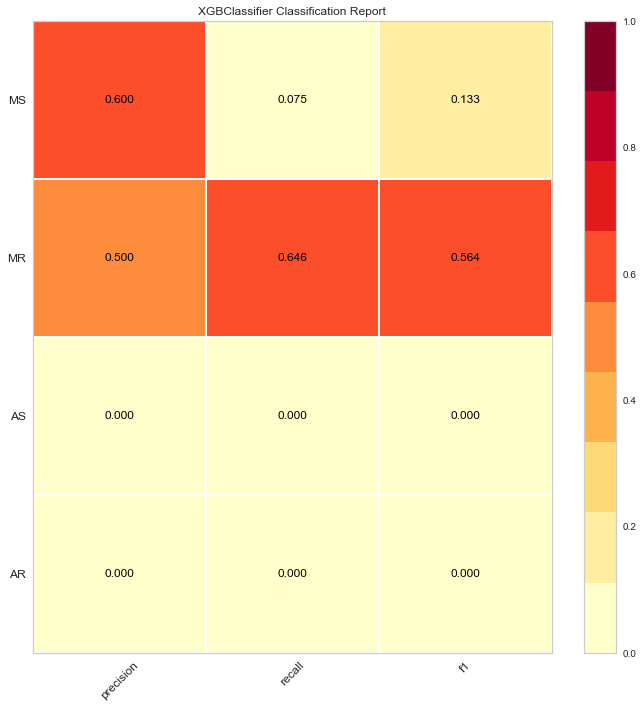

In [50]:
report = ClassificationReport(model, size=(700, 720), classes=classes)

report.score(features, y.disease1)
c = report.poof()

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


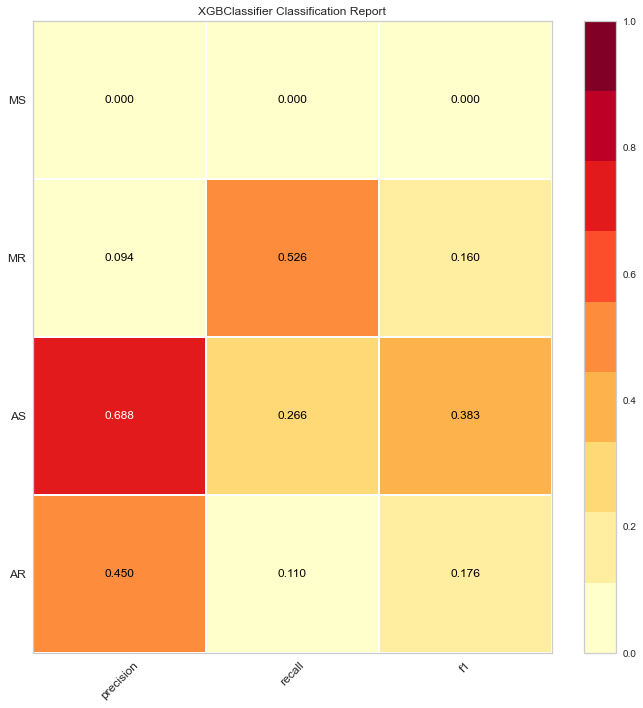

In [51]:
report = ClassificationReport(model, size=(700, 720), classes=classes)

report.score(features, y.disease2)
c = report.poof()